In [23]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
        path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

import time
from datetime import timedelta
from pprint import pprint
import corner
import numpy as np
import pickle
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS

from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.Util import data_util
from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

from utils import csv_utils

In [24]:
data_set_name = 'J9OP14010'

# J9OP02010 - complete
# J9EM25AFQ - complete
# J9OP04010 - complete

oversample_factor = 3

csv_filepath = os.path.join(repo_path, 'data', 'SLACS', 'SLACS.csv')
dataset_dict_list = csv_utils.csv_to_dict_list(csv_filepath)

dataset = [d for d in dataset_dict_list if d.get('data_set_name') == data_set_name][0]

In [25]:
# get redshifts 
z_source, z_lens = float(dataset['zBG']), float(dataset['zFG'])
print(z_source, z_lens)

# tell lenstronomy that SIE and SHEAR are at same lens redshift
lens_redshift_list = [z_lens, z_lens]

0.9818 0.2803


In [26]:
modeled_lenses_dir = os.path.join(repo_path, 'data', 'modeled_lenses')

lens_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_lens'), 'rb')
kwargs_lens = pickle.load(lens_file)
lens_file.close()

lens_light_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_lens_light'), 'rb')
kwargs_lens_light = pickle.load(lens_light_file)
lens_light_file.close()

source_file = open(os.path.join(modeled_lenses_dir, data_set_name + '_source'), 'rb')
kwargs_source_light = pickle.load(source_file)
source_file.close()

# pprint(kwargs_lens)
# print('-------------------')
# pprint(kwargs_lens_light)
# print('-------------------')
# pprint(kwargs_source_light)

In [27]:
# mass model
lens_model_list = ['SIE', 'SHEAR']
lens_model_class = LensModel(lens_model_list=lens_model_list, z_source=z_source, lens_redshift_list=lens_redshift_list, multi_plane=True)

# light model
lens_light_model_list = ['SERSIC_ELLIPSE']
lens_light_model_class = LightModel(lens_light_model_list)

# source model
source_model_list = ['SERSIC_ELLIPSE']
source_model_class = LightModel(source_model_list)

kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'source_light_model_list': source_model_list}

kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

kwargs_numerics = {'supersampling_factor': 4,
                'supersampling_convolution': False}

0.13292070140428686 0.0038082996914711722
[  4.29943391 -12.63962006]


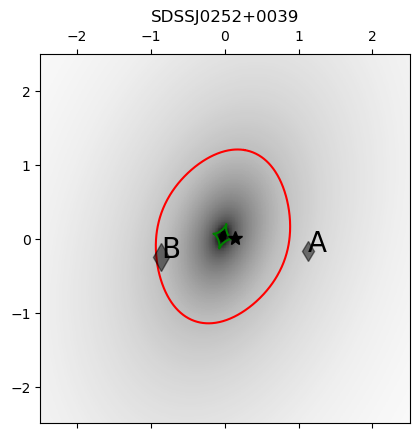

In [28]:
# source plane coordinates of source
beta_ra, beta_dec = kwargs_source_light[0]['center_x'], kwargs_source_light[0]['center_y']
print(beta_ra, beta_dec)

# specifiy the lens model class to deal with
solver = LensEquationSolver(lens_model_class)

# solve for image positions provided a lens model and the source position
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

# the magnification of the point source images
mag = lens_model_class.magnification(theta_ra, theta_dec, kwargs_lens)
print(mag)

# plot
f, axes = plt.subplots()
lens_plot.lens_model_plot(axes, lensModel=lens_model_class, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
axes.set_title(dataset.get('target_name'))
f.show()
f.savefig(os.path.join(repo_path, 'figures', 'lenstronomy_modeling', data_set_name + '_caustics.png'))

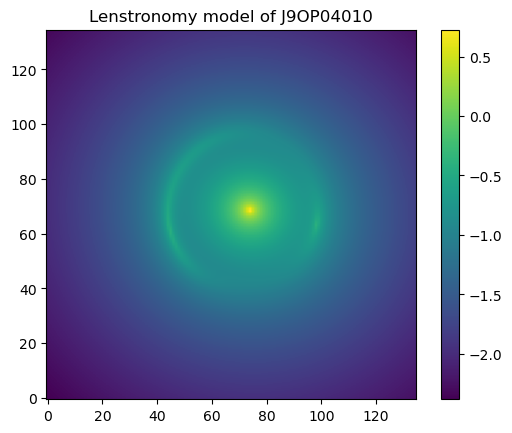

In [29]:
side = 5  # arcseconds
num_pix = 45 * oversample_factor
delta_pix = side / num_pix  # size of pixel in angular coordinates

ra_at_xy_0, dec_at_xy_0 = -delta_pix * math.ceil(num_pix / 2), -delta_pix * math.ceil(num_pix / 2) # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * delta_pix  # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

imageModel = ImageModel(data_class=pixel_grid,
                        psf_class=psf_class,
                        lens_model_class=lens_model_class,
                        source_model_class=source_model_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

image = imageModel.image(kwargs_lens=kwargs_lens,
                        kwargs_source=kwargs_source_light,
                        kwargs_lens_light=kwargs_lens_light)

plt.imshow(np.log10(image))
plt.title('Lenstronomy model of '+ data_set_name)
# plt.savefig(os.path.join('figures', 'pixel_density_test', 'model_' + str(oversample_factor) + '.png'))
plt.colorbar()
plt.show()

model_array_path = os.path.join(repo_path, 'arrays', 'SLACS', dataset.get('target_name') + '_model_' + str(oversample_factor) + '.npy')
# np.save(model_array_path, image)